# Tree models

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# Import data
from Preprocessing import X, Y, n_fold, cv, random_split 
trainX, trainY, testX, testY = random_split(0.8)

In [72]:
# K-fold cross validation function
def k_fold_cross_validation(MODEL, range_hyperparam: list, hyperparam_name, additional_params=None) -> np.array:
    """Performs k-fold cross validation for a given model and hyperparameter / range of hyperparameter"""
    acc = np.zeros(len(range_hyperparam))
    for train_index, val_index in cv.split(X): # Loopar över alla folds
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]

        for j,k in enumerate(range_hyperparam): # Tree classifier for each depth
            kwargs = {hyperparam_name: k}
            if additional_params is not None:
                kwargs.update(additional_params)
            model = MODEL(**kwargs)
            model.fit(X_train, Y_train)
            acc[j] += model.score(X_val, Y_val)

    acc /= n_fold # ta average av alla average accuracies
    return acc

def best_hyperparam(acc, range_hyperparam, model, hyperparam_name):
    """Returns the best hyperparameter based on the accuracy"""
    best_hyperparam = range_hyperparam[np.argmax(acc)]
    BestModel = model(**{hyperparam_name: best_hyperparam})
    BestModel.fit(trainX, trainY)
    
    print('Accuracy with best hyperparameter: ', np.max(acc))
    print('Best hyperparameter: ', best_hyperparam, '\n')   
    print('Confusion matrix:')
    print(pd.crosstab(testY, BestModel.predict(testX), rownames=['True'], colnames=['Predicted'], margins=False))
    pd.crosstab(testY, BestModel.predict(testX), rownames=['True'], colnames=['Predicted'], margins=False)
        

### Classification Tree

1 tree different max depth:

In [71]:
depths = range(1, 150)
acc = k_fold_cross_validation(tree.DecisionTreeClassifier, depths, 'max_depth')

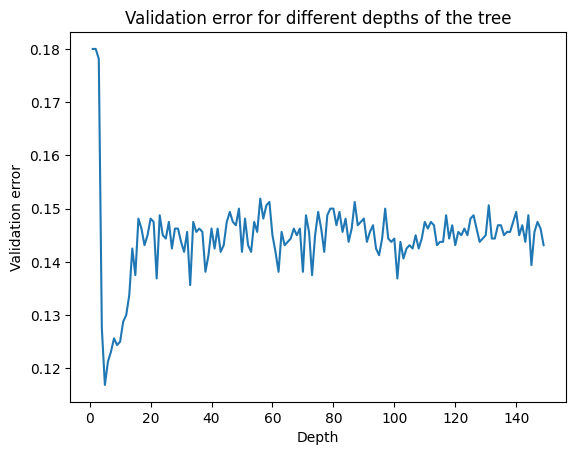

In [110]:
plt.plot(depths, 1- acc)
plt.xlabel('Depth')
plt.ylabel('Validation error')
plt.title('Validation error for different depths of the tree')
plt.show()

In [ ]:
print(f'Best depth tree \n')
best_hyperparam(acc, depths, tree.DecisionTreeClassifier, 'max_depth')

Best depth tree 

Accuracy with best hyperparameter:  0.8831249999999999
Best hyperparameter:  5 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                34               18
low_bike_demand                 17              251


## Bagging

Test different number of trees:

In [94]:
trees = range(1, 150)
acc_bag = k_fold_cross_validation(BaggingClassifier, trees, 'n_estimators', {'random_state': 0})


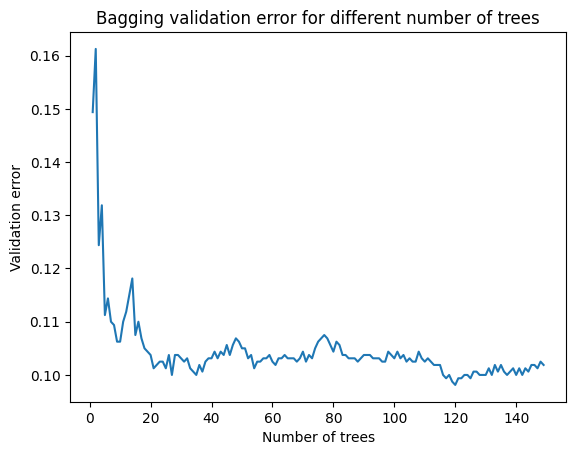

In [95]:
plt.plot(trees, 1 - acc_bag)
plt.xlabel('Number of trees')
plt.ylabel('Validation error')
plt.title('Bagging validation error for different number of trees')
plt.show()

In [88]:
print('Best number of trees for bagging \n')
best_hyperparam(acc_bag, trees, BaggingClassifier, 'n_estimators')


Best number of trees for bagging 

Accuracy with best hyperparameter:  0.903125
Best hyperparameter:  135 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                39               14
low_bike_demand                 10              257


## Random Forest

Random forest with different number of trees

In [92]:
trees = range(1, 150)
acc_randf = k_fold_cross_validation(RandomForestClassifier, trees, 'n_estimators', {'random_state': 0})

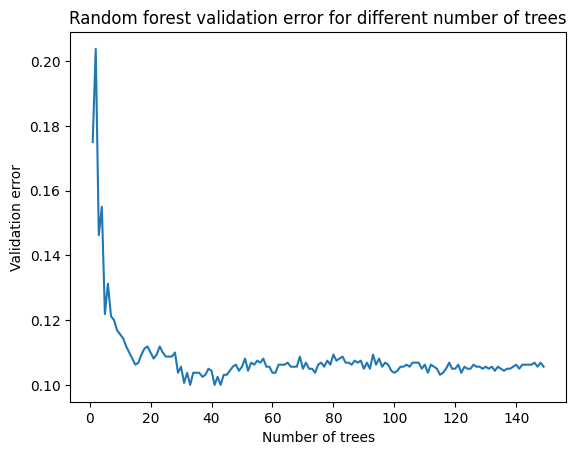

In [93]:
plt.plot(trees, 1 - acc_randf)
plt.xlabel('Number of trees')
plt.ylabel('Validation error')
plt.title('Random forest validation error for different number of trees')
plt.show()

In [84]:
print('Best number of trees for random forest \n')
best_hyperparam(acc_randf, trees, RandomForestClassifier, 'n_estimators')

Best number of trees for random forest 

Accuracy with best hyperparameter:  0.9025000000000001
Best hyperparameter:  87 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                29               24
low_bike_demand                  7              260


In [85]:
# Compare all models
plt.plot(trees, 1 - acc_bag, label='Bagging')
plt.plot(trees, 1 - acc_randf, label='Random forest')
plt.plot(depths, 1 - acc, label='Decision tree')

plt.xlabel('Number of trees/depth of tree')
plt.ylabel('Validation error')
plt.title('Comparison of different models')
plt.legend()
plt.show()

NameError: name 'acc_bag' is not defined

See that the bagging and random forest models perform equal. The decision tree seem to have optimal performance at a depth of ~5. Use this tree as the estimators for bagging and random forest:

In [77]:
trees2 = range(1, 150)
bestTree = tree.DecisionTreeClassifier(max_depth=5)

acc_bag2 = k_fold_cross_validation(BaggingClassifier, trees2, 'n_estimators', {'estimator': bestTree})
acc_randf2 = k_fold_cross_validation(RandomForestClassifier, trees2, 'n_estimators', {'max_depth': 5})


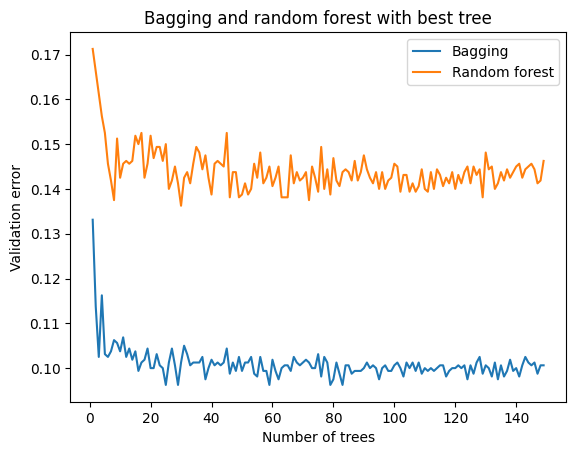

In [78]:
plt.plot(trees2, 1 - acc_bag2)
plt.plot(trees2, 1 - acc_randf2)
plt.xlabel('Number of trees')
plt.ylabel('Validation error')
plt.title('Bagging and random forest with best tree')
plt.legend(['Bagging', 'Random forest'])
plt.show()

In [79]:
print('Best number of trees for bagging with best tree \n')
best_hyperparam(acc_bag2, trees2, BaggingClassifier, 'n_estimators')
print('\n-----------------------------------------------------\n')
print('Best number of trees for random forest with best tree \n')
best_hyperparam(acc_randf2, trees2, RandomForestClassifier, 'n_estimators')

Best number of trees for bagging with best tree 

Accuracy with best hyperparameter:  0.9037499999999999
Best hyperparameter:  25 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                37               16
low_bike_demand                 11              256

-----------------------------------------------------

Best number of trees for random forest with best tree 

Accuracy with best hyperparameter:  0.8637500000000001
Best hyperparameter:  30 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                31               22
low_bike_demand                  9              258
